In [61]:
!pip install transformers
!pip install sentencepiece
!pip install segtok

!pip install vaderSentiment
!pip install nltk
!pip install huggingface_hub
!pip install pytorch-lightning

In [ ]:
import os
import sys
from pathlib import Path

import json
import pandas as pd
import random

import torch
from segtok import tokenizer

import tqdm

from multiprocessing import Pool

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import tokenize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
from pathlib import Path
ROOT_FOLDER = Path("/content/drive/My Drive/cs182_final_project/cs182-nlp")
DATA_FOLDER = ROOT_FOLDER / "dataset"
TORCH_CHECKPOINT_MODEL = ROOT_FOLDER / "final_pt_files" / "training_checkpoint_oscar_vaderless_5_class.pt"
sys.path.append(str(ROOT_FOLDER))

In [79]:
USE_VADER=False

In [65]:
import data_loader_oscar as data

In [66]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, rnn_size, vader_size, num_layers=1, dropout=0, use_vader=USE_VADER):
        super().__init__()
        #################
        #    INPUT 1    #
        #################
        # Create an embedding layer, with 768 hidden layers
        self.xlnet = torch.hub.load('huggingface/pytorch-transformers', 'model', 'xlnet-base-cased')
        for param in self.xlnet.layer.parameters():
          param.requires_grad = False
        # Output: (vocab_size x 768), where 768 hidden layers of XLNet

        # Coming in: torch.Size([BATCH_SIZE, vocab_size, 768])
        #   (XLNet has 768 hidden layers, https://huggingface.co/transformers/pretrained_models.html)
        conv2d_c_in = 1
        conv2d_c_out = 1
        conv2d_kernel_W = 5 # along Embedding Length
        conv2d_kernel_H = 5 # along Word Length

        self.conv2D_layer = nn.Conv2d(conv2d_c_in, conv2d_c_out, (conv2d_kernel_H, conv2d_kernel_W))
        # Filter of (conv2d_kernel_H, conv2d_kernel_W), Cin = 1, Cout = 1

        # Output:
        conv2d_out_Hout = vocab_size - ((conv2d_kernel_H - 1) // 2) * 2 # Vocab Size
        conv2d_out_Wout = 768 - ((conv2d_kernel_W - 1) // 2) * 2        # length

        self.max_pool_2d = nn.MaxPool2d((conv2d_out_Hout, 1))
        max_pool_2d_out_height = conv2d_out_Hout // conv2d_out_Hout
        max_pool_2d_out_length = conv2d_out_Wout // 1
        #################
        #  INPUT 1 END  #
        #################
        
        #################
        #    INPUT 2    #
        #################
        self.lstm = None
        if use_vader:
          self.lstm = nn.LSTM(input_size=1, hidden_size=1, num_layers=num_layers, batch_first=True, dropout=dropout)
        else:
          vader_size = 0
        #################
        #  INPUT 2 END  #
        #################

        self.dropout = nn.Dropout(dropout)
        # print(max_pool_2d_out_length + vader_size)

        hidden_layer_dense = 100

        self.dense = nn.Sequential(
                nn.Linear(max_pool_2d_out_length + vader_size, hidden_layer_dense),
                nn.ReLU()
            )
        self.output = nn.Linear(hidden_layer_dense, 6) # classify yelp_reviews into 5 ratings
    
    xlnet_timing = 0
    def forward_input_vectorized(self, x):
      start_time = time.time()
      xlnet_out = self.xlnet(x)
      end_time = time.time()

      self.xlnet_timing += end_time - start_time

      xlnet_out_hidden = xlnet_out.last_hidden_state
      batches_len, word_len, embedding_len = xlnet_out_hidden.shape
      xlnet_out_hidden = xlnet_out_hidden.reshape(batches_len, 1, word_len, embedding_len)
      conv2d_out = self.conv2D_layer(xlnet_out_hidden)
      result = self.max_pool_2d(conv2d_out)
      # print(result.shape)
      result = result.squeeze(1).squeeze(1)
      return result

    def forward_input_vader(self, x):
      batch_size, vader_len = x.shape
      # print(x.reshape(batch_size, vader_len, 1).shape)
      output, _ = self.lstm(x.reshape(batch_size, vader_len, 1))
      # print(output.shape)
      output = output.squeeze(2)
      return output

    def predict(self, vectorized_words, vadar_sentiments):
        logits = self.forward(vectorized_words, vadar_sentiments)
        prediction = logits.argmax(dim=1, keepdim=False)
        return prediction

    total_time_concat = 0
    def forward(self, vectorized_words, vader):
        input1 = self.forward_input_vectorized(vectorized_words)

        if False and self.lstm:
          input2 = self.forward_input_vader(vader)
          combined_input = (input1, input2)
        else:
          input2 = torch.zeros(input1.size()[0], 40)
          combined_input = (input1, input2) # Tuples need the stray comma

        # print(input1.size(), input2.size())

        start_time = time.time()
        combined_input = torch.cat(combined_input, dim=1)
        end_time = time.time()

        self.total_time_concat += end_time - start_time

        lstm_drop = self.dropout(combined_input)
        logits = self.dense(lstm_drop)
        logits = self.output(logits)
        return logits
    
    def loss_fn(self, prediction, target):
      loss_criterion = nn.CrossEntropyLoss(reduction='none')
      return torch.mean(loss_criterion(prediction, target - 1))

In [67]:
#TALLERCNN
class LanguageModelTallerCNN(nn.Module):
    def __init__(self, vocab_size, rnn_size, vader_size, num_layers=1, dropout=0, use_vader=USE_VADER):
        super().__init__()
        
        #################
        #    INPUT 1    #
        #################
        # Create an embedding layer, with 768 hidden layers
        self.xlnet = torch.hub.load('huggingface/pytorch-transformers', 'model', 'xlnet-base-cased')
        for param in self.xlnet.layer.parameters():
          param.requires_grad = False
        # Output: (vocab_size x 768), where 768 hidden layers of XLNet

        # Coming in: torch.Size([BATCH_SIZE, vocab_size, 768])
        #   (XLNet has 768 hidden layers, https://huggingface.co/transformers/pretrained_models.html)
        conv2d_c_in = 1
        conv2d_c_out = 100
        conv2d_kernel_H = 768 # along Embedding Length
        conv2d_kernel_W = 5 # along Word Length

        self.conv2D_layer = nn.Conv2d(conv2d_c_in, conv2d_c_out, (conv2d_kernel_W, conv2d_kernel_H))
        # Filter of (conv2d_kernel_W, conv2d_kernel_H), Cin = 1, Cout = 1

        # conv2d_out torch.Size([32, 100, 124, 1])

        # Output:
        conv2d_out_Wout = 1 + (vocab_size - conv2d_kernel_W) # Vocab Size
        conv2d_out_Hout = 1 + (768 - conv2d_kernel_H)       # length

        self.max_pool_2d = nn.MaxPool2d((conv2d_out_Wout, 1))
        max_pool_2d_out_length = conv2d_out_Wout // conv2d_out_Wout
        max_pool_2d_out_height = conv2d_out_Hout // 1
        #################
        #  INPUT 1 END  #
        #################
        
        #################
        #    INPUT 2    #
        #################
        self.lstm = None
        if use_vader:
          self.lstm = nn.LSTM(input_size=1, hidden_size=1, num_layers=num_layers, batch_first=True, dropout=dropout)
        else:
          vader_size = 0
        #################
        #  INPUT 2 END  #
        #################

        self.dropout = nn.Dropout(dropout)
        # print(max_pool_2d_out_height, max_pool_2d_out_length, vader_size)

        hidden_layer_dense = 100

        self.dense = nn.Sequential(
                nn.Linear(100 + vader_size, hidden_layer_dense),
                nn.ReLU()
            )
        self.output = nn.Linear(hidden_layer_dense, 5) # classify yelp_reviews into 5 ratings
    
    def forward_input_vectorized(self, x):
      xlnet_out = self.xlnet(x)
      xlnet_out_hidden = xlnet_out.last_hidden_state
      batches_len, word_len, embedding_len = xlnet_out_hidden.shape
      xlnet_out_hidden = xlnet_out_hidden.reshape(batches_len, 1, word_len, embedding_len)
      conv2d_out = self.conv2D_layer(xlnet_out_hidden)
      result = self.max_pool_2d(conv2d_out)
      result = result.squeeze(2).squeeze(2)
      return result

    def forward_input_vader(self, x):
      batch_size, vader_len = x.shape
      # print(x.reshape(batch_size, vader_len, 1).shape)
      output, _ = self.lstm(x.reshape(batch_size, vader_len, 1))
      # print(output.shape)
      output = output.squeeze(2)
      return output

    def forward(self, vectorized_words, vader):
        input1 = self.forward_input_vectorized(vectorized_words)

        if self.lstm:
          input2 = self.forward_input_vader(vader)
          combined_input = (input1, input2)
        else:
          combined_input = (input1,) # Tuples need the stray comma

        # print(input1.size(), input2.size())

        combined_input = torch.cat(combined_input, dim=1)

        lstm_drop = self.dropout(combined_input)
        logits = self.dense(lstm_drop)
        logits = self.output(logits)
        return logits

    def predict(self, vectorized_words, vadar_sentiments):
        logits = self.forward(vectorized_words, vadar_sentiments)
        prediction = logits.argmax(dim=1, keepdim=False)
        return prediction+1
    
    def loss_fn(self, prediction, target):
      loss_criterion = nn.CrossEntropyLoss(reduction='none')
      return torch.mean(loss_criterion(prediction, target - 1))

In [68]:

MAX_LEN = 128
MAX_LEN_VADER = 40
BATCH_SIZE = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_params = torch.load(
    TORCH_CHECKPOINT_MODEL, map_location=device
)

list_to_device = lambda th_obj: [tensor.to(device) for tensor in th_obj]

model = LanguageModelTallerCNN(MAX_LEN, 256, MAX_LEN_VADER)
# vocab_size, rnn_size, vader_size, num_layers=1, dropout=0, use_vader=True)

model.load_state_dict(model_params["model_state_dict"])
model = model.to(device)
model.eval()

analyzer = SentimentIntensityAnalyzer()
xlnet_tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'xlnet-base-cased')

def predict_stars(texts):
    """
    text - a SINGLE texts
    """
    # This is where you call your model to get the number of stars output
    vectorized_list = []
    vadar_sentiments_list = []
    for text in texts:
      encodings = xlnet_tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=MAX_LEN,
          return_token_type_ids=False,
          return_attention_mask=False,
          truncation=True,
          pad_to_max_length=False,
      )
      text_encoding = encodings.get("input_ids", [])
      vectorized, _ = data.pad_sequence(text_encoding, 0, MAX_LEN)
      vectorized_list.append(vectorized)

      sentence_list = nltk.tokenize.sent_tokenize(
          text
      )  # Text is one at a time anyway here
      review_sentiment_sentence = []
      for sentence in sentence_list:
          vs = analyzer.polarity_scores(sentence)
          review_sentiment_sentence.append(vs["compound"])
      vadar_sentiments, _ = data.pad_sequence(review_sentiment_sentence, 0, MAX_LEN_VADER)
      vadar_sentiments_list.append(vadar_sentiments)

    # Place the data as a batch, even if there is only 1
    vectorized = data.batch_to_torch_long(vectorized_list)
    vadar_sentiments = data.batch_to_torch_float(vadar_sentiments_list)

    p = model.predict(vectorized, vadar_sentiments)
    return p.tolist()


FileNotFoundError: ignored

In [69]:
from argparse import Namespace

args = Namespace(
    batch_size=32,
    epochs=10,
    max_len=128,
    max_len_vader=40,
    use_bert=False,
    use_cnn=True,
    use_vader=True,
)

In [70]:
def load_json(file_path, filter_function=lambda x: True):
  """
  file_path - full path of the file to read from
  filter_function - a data selection function, returns True to ADD a data point
  """
  result = []

  try:
    with open(file_path, "r") as f:
      for line in f:
        json_line = json.loads(line)
        if not filter_function(json_line):
          # Disallow via opposite of allow
          continue
        result.append(json_line) # each line is one data point dictionary
    return pd.DataFrame.from_records(result)
    # return result

  except IOError:
    print(f"cannot open {file_path}")
    return None

In [71]:
analyzer = SentimentIntensityAnalyzer()

def format_reviews(tokenizer, datatable, indices=None, task_bar=False, review_sentiment_dict=None):
  encoded_reviews = []
  encoded_reviews_mask = []
  review_sentiment = []
  reviews_to_process = datatable[["review_id", "text", "stars"]]
  # display(reviews_to_process)
  if indices is not None:
    reviews_to_process = reviews_to_process.iloc[indices]
  
  review_iterator = reviews_to_process.iterrows()
  if task_bar:
    review_iterator = tqdm.notebook.tqdm(reviews_to_process.iterrows(), total=reviews_to_process.shape[0])

  for i, review in review_iterator:
    # Tokenize by TOKENIZER
    review_text = review["text"]
    numerized = tokenize_review(tokenizer, review_text)
    padded, mask = pad_sequence(numerized, 0, MAX_LEN)
    encoded_reviews.append(padded)
    encoded_reviews_mask.append(mask)
    # VADER
    if review_sentiment_dict is None:
      sentence_list = nltk.tokenize.sent_tokenize(review_text)
      review_sentiment_sentence = []
      for sentence in sentence_list:
          vs = analyzer.polarity_scores(sentence)
          review_sentiment_sentence.append(vs["compound"])
      padded, _ = pad_sequence(review_sentiment_sentence, 0, MAX_LEN_VADER)
      review_sentiment.append(padded)
    else:
      if review["review_id"] in review_sentiment_dict:
        review_sentiment.append(review_sentiment_dict[review["review_id"]])
    
  torch_encoded_reviews, torch_encoded_reviews_target = \
                    batch_to_torch_long(encoded_reviews, reviews_to_process["stars"].values)
  torch_encoded_reviews_mask, torch_review_sentiment = batch_to_torch_float(encoded_reviews_mask, review_sentiment)
  return torch_encoded_reviews, torch_encoded_reviews_target, torch_review_sentiment, torch_encoded_reviews_mask

In [72]:
def batch_to_torch_long(*batches):
  if len(batches) == 1:
    return torch.LongTensor(batches[0])
  return [torch.LongTensor(batch) for batch in batches]

def batch_to_torch_float(*batches):
  if len(batches) == 1:
    return torch.FloatTensor(batches[0])
  return [torch.FloatTensor(batch) for batch in batches]

In [73]:
def pad_sequence(numerized, pad_index, to_length, beginning=True):
    pad = numerized[:to_length]
    if beginning:
      padded = [pad_index] * (to_length - len(pad)) + pad
    else:
      padded = pad + [pad_index] * (to_length - len(pad))
    mask = [w != pad_index for w in padded]
    return padded, mask

In [74]:
def tokenize_review(tokenizer, review_text):
  encodings = tokenizer.encode_plus(review_text, add_special_tokens=True,
                                    max_length=MAX_LEN,
                                    return_token_type_ids=False,
                                    return_attention_mask=False,
                                    truncation=True,
                                    pad_to_max_length=False)
  return encodings.get("input_ids", [])

In [75]:
count = 0
total_time = 0

model.eval()

model.total_time_concat = 0
model.xlnet_timing = 0
predictions=[]



if len(sys.argv) > 1:
    validation_file = str(DATA_FOLDER / "yelp_review_training_dataset.jsonl")
    with open("output.jsonl", "w") as fw:
        pandas_dataset = data.load_json(validation_file)
        pandas_dataset = pandas_dataset[:1000]
        full_table = pandas_dataset.copy(deep=True)
        dataset_batch_cap = ( pandas_dataset.shape[0] // BATCH_SIZE ) + (1 if pandas_dataset.shape[0] % BATCH_SIZE > 0 else 0)
        
        t = tqdm.notebook.tqdm(range(0, dataset_batch_cap), initial = 0, total = dataset_batch_cap)
        
        for i in t:
          val_start_i = i*BATCH_SIZE
          val_end_i = (i+1)*BATCH_SIZE
          # print(val_start_i, val_end_i, indices.shape)

          data_subset = pandas_dataset.iloc[val_start_i:val_end_i]
          
          # batch
          batch_val = data.format_reviews(args, datatable=data_subset)

          """
          return (
              torch.LongTensor(encoded_reviews),  # text
              torch.FloatTensor(review_sentiments),  # sentiments
              torch.LongTensor(reviews_to_process["stars"].values),  # target
              torch.FloatTensor(encoded_reviews_mask),  # mask
          )
          """
          start_time = time.time()
          (batch_input_val, batch_review_sentiment_val, batch_target_val, batch_target_mask_val) = batch_val
          # print(batch_input_val.shape, batch_review_sentiment_val.shape)
          (batch_input_val, batch_target_val) = list_to_device((batch_input_val, batch_target_val))
          batch_target_mask_val, batch_review_sentiment_val = list_to_device((batch_target_mask_val, batch_review_sentiment_val))
          end_time = time.time()
          print("process time", end_time - start_time)

          # forward pass
          start_time = time.time()
          prediction = model.predict(batch_input_val, batch_review_sentiment_val)
          end_time = time.time()
          total_time += end_time - start_time

          # print(prediction)
          for i, pred_val in enumerate(prediction):
            pred_val = pred_val.item()
            count += 1
            fw.write(
                json.dumps(
                    {
                        "review_id": data_subset.iloc[i]["review_id"],
                        "predicted_stars": float(pred_val),
                    }
                )
                + "\n"
            )

            predictions.append(float(pred_val))
          print(count, total_time, model.total_time_concat, total_time - model.total_time_concat)
          print("xlnet_timing", model.xlnet_timing)
    full_table['pred'] = predictions
    print(full_table[['text', 'stars', 'pred']])
    print("Output prediction file written")
else:
    print("No validation file given")

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
64it [00:00, 333.31it/s]


process time 0.0028460025787353516
64 45.892333030700684 0 45.892333030700684
xlnet_timing 0


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
64it [00:00, 401.24it/s]


process time 0.0009753704071044922
128 80.2061882019043 0 80.2061882019043
xlnet_timing 0


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
64it [00:00, 364.42it/s]


process time 7.62939453125e-05
192 114.21851968765259 0 114.21851968765259
xlnet_timing 0


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
64it [00:00, 349.38it/s]


process time 0.0001232624053955078
256 148.3859829902649 0 148.3859829902649
xlnet_timing 0


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
64it [00:00, 342.20it/s]


process time 0.00041031837463378906
320 182.45798206329346 0 182.45798206329346
xlnet_timing 0


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
64it [00:00, 416.84it/s]


process time 6.67572021484375e-05
384 216.4841468334198 0 216.4841468334198
xlnet_timing 0


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
64it [00:00, 409.10it/s]


process time 6.29425048828125e-05
448 250.27756929397583 0 250.27756929397583
xlnet_timing 0


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
64it [00:00, 422.44it/s]


process time 6.628036499023438e-05
512 284.1543462276459 0 284.1543462276459
xlnet_timing 0


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
64it [00:00, 447.15it/s]


process time 7.557868957519531e-05
576 318.14527583122253 0 318.14527583122253
xlnet_timing 0


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
64it [00:00, 364.07it/s]


process time 0.0011687278747558594
640 351.994845867157 0 351.994845867157
xlnet_timing 0


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
64it [00:00, 354.62it/s]


process time 6.246566772460938e-05
704 385.98654294013977 0 385.98654294013977
xlnet_timing 0


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
64it [00:00, 368.76it/s]


process time 6.413459777832031e-05
768 420.04657649993896 0 420.04657649993896
xlnet_timing 0


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
64it [00:00, 318.86it/s]


process time 9.489059448242188e-05
832 454.0319514274597 0 454.0319514274597
xlnet_timing 0


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
64it [00:00, 386.85it/s]


process time 5.817413330078125e-05
896 487.915935754776 0 487.915935754776
xlnet_timing 0


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
64it [00:00, 491.31it/s]


process time 6.604194641113281e-05
960 521.9944207668304 0 521.9944207668304
xlnet_timing 0


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
40it [00:00, 382.62it/s]


process time 5.5789947509765625e-05
1000 546.2827398777008 0 546.2827398777008
xlnet_timing 0

                                                  text  stars  pred
0    Total bill for this horrible service? Over $8G...    1.0   1.0
1    I *adore* Travis at the Hard Rock's new Kelly ...    5.0   5.0
2    I have to say that this office really has it t...    5.0   5.0
3    Went in for a lunch. Steak sandwich was delici...    5.0   4.0
4    Today was my second out of three sessions I ha...    1.0   1.0
..                                                 ...    ...   ...
995  Amazing ice cream parlour!!!! We were staying ...    5.0   5.0
996  If you enjoy luxuries like electricity and run...    1.0   1.0
997  Since hiring a new gm this place has been wort...    5.0   3.0
998  We are two of many many regulars at Rainbow do...    5.0   3.0
999  I went to Chirofit after a car accident, and i...    5.0   4.0

[1000 rows x 3 columns]
Output prediction file written


In [76]:
full_table

,review_id,text,stars,pred
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1.0,1.0
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5.0,5.0
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5.0,5.0
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5.0,4.0
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1.0,1.0
...,...,...,...,...
995,TeiAGn3qkhsYgyv0S55tPA,Amazing ice cream parlour!!!! We were staying ...,5.0,5.0
996,yUTYW80FshETGWvEiln4UA,If you enjoy luxuries like electricity and run...,1.0,1.0
997,AlLMzLafPOGkc1cq_segEA,Since hiring a new gm this place has been wort...,5.0,3.0
998,33-nBp679e10xwvevM5hKA,We are two of many many regulars at Rainbow do...,5.0,3.0


In [77]:
full_table['distance'] = np.abs(full_table['stars'] - full_table['pred'])

In [ ]:
full_table.head(5)

,review_id,text,stars,pred,distance
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1.0,1.0,0.0
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5.0,5.0,0.0
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5.0,5.0,0.0
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5.0,4.0,1.0
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1.0,1.0,0.0


In [ ]:
sum(full_table['distance'])/1000

0.624

In [ ]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

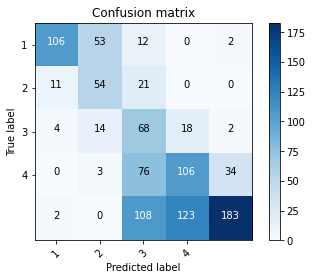

In [ ]:
# compute the confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
confusion_mtx = confusion_matrix(full_table['stars'], full_table['pred']) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(1,5))
plt.show()